In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display
# inline plotting instead of popping out
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
from numpy.random import seed

class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1 , M=1):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.M = M            #minibatch
        if random_state:
            seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        self.mini_xi = np.empty((0,2), float)    ####
        self.target = np.empty((0,1), int)      ####
        self.count = 0                         ####SS
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                self.count += 1
                self.mini_xi  = np.vstack((self.mini_xi , xi))
                self.target  = np.vstack((self.target , np.atleast_1d(target)))
                if(self.count == self.M):
                    #print(self.count)
                    self.count =0
                    #print(self.mini_xi)
                    #print(self.target)
                    cost.append(self._update_weights(self.mini_xi, self.target))
                    #print(cost)
                    self.mini_xi = np.empty((0,2), float)
                    self.target = np.empty((0,1), int)
            #print(len(cost))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)
        #print(target.flatten())
        error = (target.flatten() - output)
        #print(self.w_[1:].shape)
        
        #print(xi.shape)
        #print(self.eta * xi.T.dot(error))
        #print(self.w_[1:] )
        self.w_[1:] += self.eta * xi.T.dot(error)
        #print(self.w_[1:])
        #print(xi.T.dot(error).shape)
        #print('yo')
        #print(self.w_[1:])
        self.w_[0] += self.eta * error.sum()
        #print(error)
        #print(error.sum())
        cost = 0.5 * (error**2).sum()
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

M=1_Misclassified samples: 3
M=1_Accuracy: 0.85
M=2_Misclassified samples: 3
M=2_Accuracy: 0.85
M=80_Misclassified samples: 3
M=80_Accuracy: 0.85


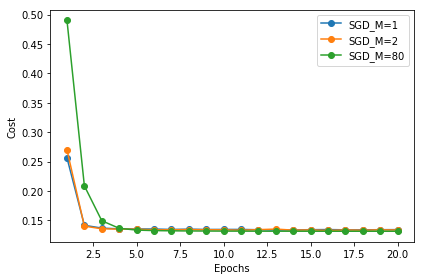

In [5]:

adas = AdalineSGD(n_iter=20, eta=0.01, random_state=1 , M = 1)
adas.fit(X_train_std, y_train)
#print(adas.cost_)
plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, 
         marker='o', label='SGD_M=1')

y_pred = adas.predict(X_test_std)
print('M=1_Misclassified samples: %d' % (y_test != y_pred).sum())
print('M=1_Accuracy: %.2f' % accuracy_score(y_test, y_pred))


adas = AdalineSGD(n_iter=20, eta=0.01, random_state=1 , M = 10)
adas.fit(X_train_std, y_train)
plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, 
         marker='o', label='SGD_M=2')
print('M=2_Misclassified samples: %d' % (y_test != y_pred).sum())
print('M=2_Accuracy: %.2f' % accuracy_score(y_test, y_pred))


adas = AdalineSGD(n_iter=20, eta=0.01, random_state=1 , M = 80)
adas.fit(X_train_std, y_train)
plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, 
         marker='o', label='SGD_M=80')
print('M=80_Misclassified samples: %d' % (y_test != y_pred).sum())
print('M=80_Accuracy: %.2f' % accuracy_score(y_test, y_pred))
# cost values


plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('./output/Lab04-1_107062616.png', dpi=300)
plt.show()
# testing accuracy



